#**Ex.3 HW3 - Training VAE+SVM for classification with pytorch**

# **Hyperparameters**

In [1]:
epochs = 50
inputSize = 28*28
Hidden_dim = 600
Hidden_n = 2
Latent_dim = 50
batch_size = 50
learning_rate = 1e-3
MNISTtype = 1 # 1 for FashionMNIST Dataset, otherwise digits
folderpath = '/content/drive/My Drive/DL_TAU2019/ex3_300746930_034915504/'

# General Setup
This section includes general/pre-code part

Mounting the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


Install and import all the req. lib.

In [3]:
!pip install torch numpy torchvision matplotlib tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import random as rnd
from sklearn.metrics import accuracy_score
from sklearn import svm
import pickle
torch.manual_seed(0)
# Connect to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device != "cpu":
  print("GPU is available")
else:
  print("Work on CPU")

GPU is available


Dataset loading

In [4]:
if MNISTtype == 1:
  train_dataset = dsets.FashionMNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

  test_dataset = dsets.FashionMNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())
else:
  train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

  test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())
# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Make sure that it is Fashion

5


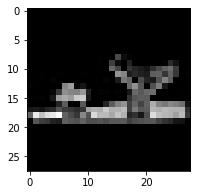

In [5]:
print(train_dataset[-1][1])
img = train_dataset[-1][0]
# get one image from the bat
img = np.squeeze(img[0])
fig = plt.figure(figsize = (3,3)) 
plt.imshow(img, cmap='gray')

**VAE Classes and Training**
Encoder - for a given image the encoder generats a latent vector

In [6]:
class Encoder(nn.Module):

  def __init__(self, input_dim, hidden_dim, Latent_dim):

      super().__init__()

      self.linear = nn.Linear(input_dim, hidden_dim)
      self.mu = nn.Linear(hidden_dim, Latent_dim)
      self.var = nn.Linear(hidden_dim, Latent_dim)

  def forward(self, x):
      # x is of shape [batch_size, input_dim]

      hidden = F.relu(self.linear(x))
      # hidden is of shape [batch_size, hidden_dim]
      Latent_mu = self.mu(hidden)
      # z_mu is of shape [batch_size, latent_dim]
      Latent_var = self.var(hidden)
      # z_var is of shape [batch_size, latent_dim]

      return Latent_mu, Latent_var

Decoder - For a given latent vector generates an image (Vector represntation)

In [7]:
class Decoder(nn.Module):

  def __init__(self, Latent_dim, hidden_dim, output_dim):

      super().__init__()

      self.linear = nn.Linear(Latent_dim, hidden_dim)
      self.out = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):


      hidden = F.relu(self.linear(x))


      predicted = torch.log(1 + torch.exp(self.out(hidden)))

      return predicted

VAE class Includes the sampling trick

In [8]:
class VAE(nn.Module):

  def __init__(self, enc, dec):
      super().__init__()

      self.enc = enc
      self.dec = dec

  def forward(self, x):
      # encode
      Latent_mu, Latent_var = self.enc(x)


      std = torch.exp(Latent_var / 2)
      eps = torch.randn_like(std)
      x_sample = eps.mul(std).add_(Latent_mu)

      # decode
      predicted = self.dec(x_sample)
      return predicted, Latent_mu, Latent_var


**Training and Tesing Functions for VAE**

Train function

In [9]:
def train(model,optimizer):
  model.train()
  train_loss = 0
  for i, (x, _) in enumerate(train_loader):
    x = x.view(-1, 28 * 28)
    x = x.to(device)
    optimizer.zero_grad()
    x_VAE, Latent_mu, Latent_var = model(x)         
    recon_loss = F.mse_loss(x_VAE, x,reduction='sum')      
    kl_loss = -0.5 * torch.sum(1 + Latent_var - Latent_mu.pow(2) - Latent_var.exp())
    loss = recon_loss + kl_loss
    loss.backward()
    train_loss += loss.item()/len(train_loader)
    optimizer.step()
  return train_loss

Test function

In [10]:
def test(model,optimizer):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
      x = x.view(-1, 28 * 28)
      x = x.to(device)
      x_VAE, Latent_mu, Latent_var = model(x)      
      recon_loss = F.mse_loss(x_VAE, x,reduction='sum')         
      kl_loss = -0.5 * torch.sum(1 + Latent_var - Latent_mu.pow(2) - Latent_var.exp())     
      loss = recon_loss + kl_loss
      test_loss += loss.item()/len(test_loader)

  return test_loss


**Functions for SVM**

build a training data using VAE

In [11]:
def bulidSmallDataSet(train_dataset, n, Nclasses = 10):
  Features = torch.empty([n,28,28]);
  Labels = torch.empty(n, dtype=int);
  samplesPerClass = int(n / Nclasses)
  # print(samplesPerClass)
  sampelIdx = 0;
  for i in range(Nclasses):
    Nsamp = 0
    for s,data in enumerate(train_dataset):
      img, label = data
      
      if (label == i):
        
        Features[sampelIdx,:,:] = img
        Labels[sampelIdx] = label
        sampelIdx += 1
        Nsamp += 1
      
      if Nsamp >= samplesPerClass:
        break
  return Features, Labels

SVM testing

In [12]:
def testSVM(test_dataset,Latent_dim,VAEmodel,SVMmodel):
  LabelsTest = np.empty(len(test_dataset), dtype=int);
  FeaturesTest = np.empty([len(test_dataset),Latent_dim]);
  SVMTest = np.empty(len(test_dataset));
  with torch.no_grad():
    for i, data in enumerate(test_dataset):
      img, label = data
      x = img.view(28*28).to(device)
      _, Latent_mu, _ = VAEmodel(x)
      Latent_mu = Latent_mu.to('cpu')
      feat = Latent_mu.numpy()
      LabelsTest[i] = label
      FeaturesTest[i,:] = feat
  FeaturesTest = FeaturesTest[:]
  SVMpredict = SVMmodel.predict(FeaturesTest)
  score = accuracy_score(LabelsTest, SVMpredict)
  # print(' * Accuracy: %.1f %%' % (100. * score))
  return score

# VAE Train

1. Train VAE

++++++++++++++++++++++++++ Training VAE ++++++++++++++++++++++++++
>>epoch 0, Train Loss: 1903.40777, Test Loss: 1568.48488
>>epoch 1, Train Loss: 1457.52529, Test Loss: 1388.39817
>>epoch 2, Train Loss: 1364.79127, Test Loss: 1355.49258
>>epoch 3, Train Loss: 1324.48704, Test Loss: 1309.05942
>>epoch 4, Train Loss: 1301.92322, Test Loss: 1292.66155
>>epoch 5, Train Loss: 1286.18990, Test Loss: 1275.54815
>>epoch 6, Train Loss: 1276.46806, Test Loss: 1269.63604
>>epoch 7, Train Loss: 1269.20846, Test Loss: 1265.54156
>>epoch 8, Train Loss: 1263.03503, Test Loss: 1265.07755
>>epoch 9, Train Loss: 1256.27620, Test Loss: 1255.32320
>>epoch 10, Train Loss: 1253.41613, Test Loss: 1264.86541
>>epoch 11, Train Loss: 1249.90251, Test Loss: 1255.11644
>>epoch 12, Train Loss: 1247.27725, Test Loss: 1251.83995
>>epoch 13, Train Loss: 1244.54067, Test Loss: 1254.63370
>>epoch 14, Train Loss: 1241.10939, Test Loss: 1242.11076
>>epoch 15, Train Loss: 1240.12575, Test Loss: 1238.82374
>>epoch 16, Tra

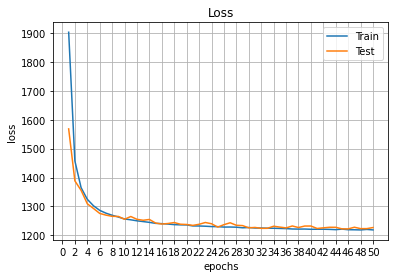

In [13]:
Trainloss = []
Testloss = []
encoder = Encoder(inputSize, Hidden_dim, Latent_dim)
decoder = Decoder(Latent_dim, Hidden_dim, inputSize)
VAEmodel = VAE(encoder, decoder).to(device)
# optimizer
optimizer = torch.optim.Adam(VAEmodel.parameters(), lr=learning_rate)
print("++++++++++++++++++++++++++ Training VAE ++++++++++++++++++++++++++")
for e in range(epochs):
  train_loss = train(VAEmodel,optimizer)
  test_loss = test(VAEmodel,optimizer)
  Trainloss.append(train_loss)
  Testloss.append(test_loss)
  print(f'>>epoch {e}, Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}')
print("+++++++++++++++++++++++++ Finish Training VAE ++++++++++++++++++++++++")
torch.save(VAEmodel.state_dict(), folderpath+'models/VAEmodel.pkl')
plt.plot(range(1,epochs+1),Trainloss, label = 'Train')
plt.plot(range(1,epochs+1),Testloss, label = 'Test')
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.title('Loss')
plt.grid(True)
plt.show()

2. Test the Training on random sample

torch.Size([50])
torch.Size([28, 28])


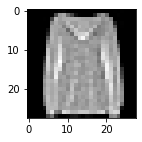

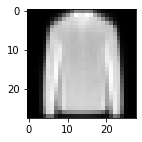

In [14]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get one image from the bat
img = np.squeeze(images[rnd.randint(0,len(images))])
fig = plt.figure(figsize = (2,2)) 
plt.imshow(img, cmap='gray')
x = img.view(28*28).to(device)
reconstructed_img, z_mu, z_var = VAEmodel(x)
img = reconstructed_img.view(28, 28).data
print(z_mu.shape)
print(img.shape)
img = img.to('cpu')
fig = plt.figure(figsize = (2,2)) 
plt.imshow(img, cmap='gray')

# SVM training and Testing

In [15]:
for n in [100, 600, 1000, 3000]:
  Images, LabelsSmall = bulidSmallDataSet(train_dataset, n,10)
  FeaturesSmall = np.empty([len(LabelsSmall),Latent_dim]);
  with torch.no_grad():
    for i, img in enumerate(Images):
      x = img.view(28*28).to(device)
      _, Latent_mu, _ = VAEmodel(x)
      Latent_mu = Latent_mu.to('cpu')
      feat = Latent_mu.numpy()
      FeaturesSmall[i,:] = feat
  FeaturesSmall = FeaturesSmall[:]
  SVMmodel = svm.SVC(kernel='rbf', decision_function_shape='ovo')
  SVMmodel.fit(FeaturesSmall, LabelsSmall)
  score = testSVM(test_dataset,Latent_dim,VAEmodel,SVMmodel)
  print(f'labels {n}, error: {100-score*100:.2f}%, Accuracy: {score*100:.2f}%')
  pickle.dump(SVMmodel, open(folderpath+'models/SVM'+str(n), 'wb'))

labels 100, error: 32.31%, Accuracy: 67.69%
labels 600, error: 23.89%, Accuracy: 76.11%
labels 1000, error: 22.75%, Accuracy: 77.25%
labels 3000, error: 20.54%, Accuracy: 79.46%


# Load and evaluate trained models
load the saved models

In [16]:
encoder = Encoder(inputSize, Hidden_dim, Latent_dim)
decoder = Decoder(Latent_dim, Hidden_dim, inputSize)
VAEmodel = VAE(encoder, decoder).to(device)
VAEmodel.load_state_dict(torch.load(folderpath+'models/VAEmodel.pkl'))
for n in [100, 600, 1000, 3000]:
  Images, LabelsSmall = bulidSmallDataSet(train_dataset, n,10)
  FeaturesSmall = np.empty([len(LabelsSmall),Latent_dim]);
  with torch.no_grad():
    for i, img in enumerate(Images):
      x = img.view(28*28).to(device)
      _, Latent_mu, _ = VAEmodel(x)
      Latent_mu = Latent_mu.to('cpu')
      feat = Latent_mu.numpy()
      FeaturesSmall[i,:] = feat
  FeaturesSmall = FeaturesSmall[:]
  SVMmodel = pickle.load(open(folderpath+'models/SVM'+str(n), 'rb'))
  score = testSVM(test_dataset,Latent_dim,VAEmodel,SVMmodel)
  print(f'labels {n}, error: {100-score*100:.2f}%, Accuracy: {score*100:.2f}%')


labels 100, error: 32.31%, Accuracy: 67.69%
labels 600, error: 23.89%, Accuracy: 76.11%
labels 1000, error: 22.75%, Accuracy: 77.25%
labels 3000, error: 20.54%, Accuracy: 79.46%
